# GenAI Assignment 1 | Gourav Garg | M25AI2164

### Setup and Hyperparameters

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


# Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATENT_DIM = 128
INITIAL_FILTERS = 32
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 40
IMAGE_CHANNELS = 3
FINAL_SPATIAL_SIZE = 4 # Encoder output (4x4)


# Data Preparation
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)



100%|██████████| 170M/170M [01:55<00:00, 1.48MB/s] 


# Model Architecture

### ENCODER

In [ ]:
# Encoding Parameters
image_channels = 3
initial_filters = 32
kernel_size = 3
stride = 2
padding = 1
latent_dim = 128

In [3]:
class Encoder(nn.Module):

  def __init__(self, image_channels, initial_filters, latent_dim):
    super(Encoder, self).__init__()

    self.image_channels = image_channels
    self.initial_filters = initial_filters
    self.latent_dim = latent_dim
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.flattened_size = 128 * 4 * 4

    # Flatten Layer
    self.flatten = nn.Flatten()
    #Layer 1
    # Input 32x32  -> Output 16x16
    # Initial filter 32 to detect different features
    self.conv1 = nn.Conv2d(
        in_channels = self.image_channels,
        out_channels = self.initial_filters,
        kernel_size = self.kernel_size,
        stride = self.stride,
        padding = self.padding
    )

    #Layer 2
    # Input 16x16 -> Output 8x8
    # To detect complex shape, now we double the filter to 64..
    self.conv2 = nn.Conv2d(
        in_channels = initial_filters,
        out_channels = initial_filters * 2,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding
    )

    #Layer 3
    # Input 8x8 -> Output 4x4
    # 128 Filters
    self.conv3 = nn.Conv2d(
        in_channels = initial_filters*2,
        out_channels = initial_filters * 4,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding
        )

    # we will extract 128(latent dimentsion) from 2048(flattened size)
    self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
    self.fc_var = nn.Linear(self.flattened_size, latent_dim)

  def forward(self, x):
    x = torch.relu(self.conv1(x))
    x = torch.relu(self.conv2(x))
    x = torch.relu(self.conv3(x))
    x = self.flatten(x)

    mu = self.fc_mu(x)
    log_var = self.fc_var(x)
    return mu, log_var



### DECODER

In [ ]:
# Decoding Parameters
latent_dim = 128
initial_filters = 32     # Base filters
final_spatial_size = 4   # Encoder image output 4x4
decoder_start_channels = initial_filters * 4  # 128 filters

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, initial_filters, final_spatial_size):
        super(Decoder, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.latent_dim = latent_dim
        self.initial_filters = initial_filters
        self.final_spatial_size = final_spatial_size

        # Calculate the number of input features for the linear layer
        # 128 filters * 4 * 4 pixels = 2048
        self.start_filters = initial_filters * 4
        self.fc_input_dim = self.start_filters * final_spatial_size * final_spatial_size

        # Latent vector (128) to 2048
        self.fc = nn.Linear(latent_dim, self.fc_input_dim)

        # # Upsampling
        # # 4x4 -> 8x8
        # self.deconv1 = nn.ConvTranspose2d(in_channels=self.start_filters,
        #                                   out_channels=initial_filters * 2,
        #                                   kernel_size=kernel_size, stride=stride, padding=padding)

        # # 8x8 -> 16x16
        # self.deconv2 = nn.ConvTranspose2d(in_channels=initial_filters * 2,
        #                                   out_channels=initial_filters,
        #                                   kernel_size=kernel_size, stride=stride, padding=padding)

        # # 16x16 -> 32x32 (Final RGB Image)
        # self.deconv3 = nn.ConvTranspose2d(in_channels=initial_filters,
        #                                   out_channels=3, # Red, Green, Blue
        #                                   kernel_size=kernel_size, stride=stride, padding=padding)

        self.deconv1 = nn.ConvTranspose2d(self.start_filters, initial_filters * 2,
                                  kernel_size=4, stride=2, padding=1)

        # 8x8 -> 16x16
        self.deconv2 = nn.ConvTranspose2d(initial_filters * 2, initial_filters,
                                          kernel_size=4, stride=2, padding=1)

        # 16x16 -> 32x32
        self.deconv3 = nn.ConvTranspose2d(initial_filters, 3,
                                          kernel_size=4, stride=2, padding=1)


    def forward(self, z):
        # 1. Linear layer to expand features
        x = self.fc(z)

        # 2. Reshape: Flat vector to ch*h*width
        x = x.view(-1, self.start_filters, final_spatial_size, final_spatial_size)

        # 3. Upsampling with Activations
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))

        # 4. Sigmoid to get pixel bw 0 and 1
        x = torch.sigmoid(self.deconv3(x))
        return x

In [6]:
def reparameterize(mu, log_var):
  # 1. Standard Deviation, 0.5 to address log variance.
  std = torch.exp(0.5 * log_var)

  # 2. Random Noise (epsilon)
  eps = torch.randn_like(std)

  # 3. Gradient Flow final Sample Z
  z = mu + (eps * std)

  return z

### VAE MODEL

In [7]:
class VAE(nn.Module):
    def __init__(self, image_channels, initial_filters, latent_dim, final_spatial_size):
        super(VAE, self).__init__()

        # Encoder: Image -> mean and variance
        self.encoder = Encoder(image_channels, initial_filters, latent_dim)

        # Decoder: z -> Reconstructed Image
        self.decoder = Decoder(latent_dim, initial_filters, final_spatial_size)

    def forward(self, x):
        # 1. Encoding
        mu, log_var = self.encoder(x)

        # 2. Sampling or Latent vector space
        z = reparameterize(mu, log_var)

        # 3. Decoding
        recon_image = self.decoder(z)

        return recon_image, mu, log_var


### LOSS FUNCTION AND TRAINING

In [8]:
def vae_loss_function(recon_x, x, mu, log_var, beta_value):
    # 1. Reconstruction Loss
    # reduction='sum' to get loss of entire batch
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # 2. KL Divergence
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    total_loss = recon_loss + (beta_value * kld_loss)

    return total_loss, recon_loss, kld_loss

In [9]:
def train_one_epoch(model, dataloader, optimizer, beta):
    model.train()
    total_train_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0

    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(DEVICE)
        optimizer.zero_grad()

        # Forward pass
        recon_images, mu, log_var = model(images)

        # Loss calculation
        loss, r_loss, k_loss = vae_loss_function(recon_images, images, mu, log_var, beta)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate losses
        total_train_loss += loss.item()
        total_recon_loss += r_loss.item()
        total_kld_loss += k_loss.item()
    
    # Calculate averages
    num_samples = len(dataloader.dataset)
    avg_total_loss = total_train_loss / num_samples
    avg_recon_loss = total_recon_loss / num_samples
    avg_kld_loss = total_kld_loss / num_samples

    return avg_total_loss, avg_recon_loss, avg_kld_loss

## TASK 2 | Experiment 1 - Baseline Training (beta=1.0)

In [10]:
model_beta1 = VAE(IMAGE_CHANNELS, INITIAL_FILTERS, LATENT_DIM, FINAL_SPATIAL_SIZE).to(DEVICE)
optimizer = optim.Adam(model_beta1.parameters(), lr=LEARNING_RATE)

train_losses_beta1 = []
recon_losses_beta1 = []
kld_losses_beta1 = []

print("Starting Baseline Training (Beta=1.0)...")
for epoch in range(EPOCHS):
    avg_loss, avg_r_loss, avg_k_loss = train_one_epoch(model_beta1, train_loader, optimizer, beta=1.0)
    
    train_losses_beta1.append(avg_loss)
    recon_losses_beta1.append(avg_r_loss)
    kld_losses_beta1.append(avg_k_loss)
    
    print(f'Epoch {epoch+1}: Total Loss: {avg_loss:.4f} | Recon Loss: {avg_r_loss:.4f} | KL Loss: {avg_k_loss:.4f}')

Starting Baseline Training (Beta=1.0)...
Epoch 1: Total Loss: 2027.9693 | Recon Loss: 2014.3849 | KL Loss: 13.5844
Epoch 2: Total Loss: 1915.7422 | Recon Loss: 1887.4805 | KL Loss: 28.2617
Epoch 3: Total Loss: 1892.6092 | Recon Loss: 1862.5989 | KL Loss: 30.0103
Epoch 4: Total Loss: 1873.8041 | Recon Loss: 1843.5368 | KL Loss: 30.2673
Epoch 5: Total Loss: 1856.7920 | Recon Loss: 1824.9191 | KL Loss: 31.8729
Epoch 6: Total Loss: 1849.8708 | Recon Loss: 1817.2426 | KL Loss: 32.6282
Epoch 7: Total Loss: 1845.2253 | Recon Loss: 1811.6547 | KL Loss: 33.5706
Epoch 8: Total Loss: 1841.5704 | Recon Loss: 1806.9898 | KL Loss: 34.5807
Epoch 9: Total Loss: 1838.8810 | Recon Loss: 1803.4545 | KL Loss: 35.4265
Epoch 10: Total Loss: 1836.5868 | Recon Loss: 1800.4584 | KL Loss: 36.1284
Epoch 11: Total Loss: 1834.8945 | Recon Loss: 1798.1110 | KL Loss: 36.7835
Epoch 12: Total Loss: 1833.4328 | Recon Loss: 1796.1502 | KL Loss: 37.2826
Epoch 13: Total Loss: 1832.2823 | Recon Loss: 1794.5305 | KL Loss: 3

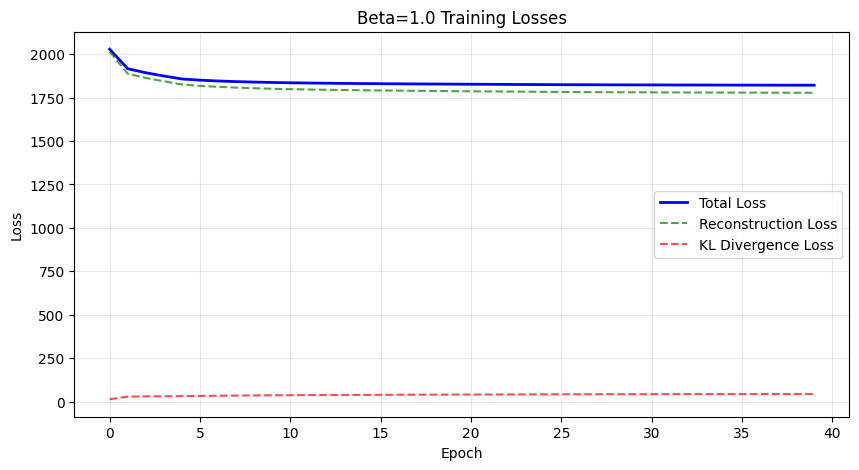

In [11]:
import matplotlib.pyplot as plt

def plot_all_losses(total_losses, recon_losses, kld_losses, title="Training Losses"):
    plt.figure(figsize=(10, 5))
    
    plt.plot(total_losses, label="Total Loss", color='blue', linewidth=2)
    
    plt.plot(recon_losses, label="Reconstruction Loss", color='green', linestyle='--', alpha=0.7)
    
    plt.plot(kld_losses, label="KL Divergence Loss", color='red', linestyle='--', alpha=0.7)
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_all_losses(train_losses_beta1, recon_losses_beta1, kld_losses_beta1, title="Beta=1.0 Training Losses")

## TASK 4 | Experiment 2 - Disentanglement (beta=5.0)

In [12]:
model_beta5 = VAE(IMAGE_CHANNELS, INITIAL_FILTERS, LATENT_DIM, FINAL_SPATIAL_SIZE).to(DEVICE)
optimizer_beta5 = optim.Adam(model_beta5.parameters(), lr=LEARNING_RATE)

train_losses_beta5 = []
recon_losses_beta5 = []
kld_losses_beta5 = []

print("\nStarting Experiment Training (Beta=5.0)...")
for epoch in range(EPOCHS):
    avg_loss, avg_r_loss, avg_k_loss = train_one_epoch(model_beta5, train_loader, optimizer_beta5, beta=5.0)
    
    train_losses_beta5.append(avg_loss)
    recon_losses_beta5.append(avg_r_loss)
    kld_losses_beta5.append(avg_k_loss)
    
    print(f'Epoch {epoch+1}: Total Loss: {avg_loss:.4f} | Recon Loss: {avg_r_loss:.4f} | KL Loss: {avg_k_loss:.4f}')


Starting Experiment Training (Beta=5.0)...
Epoch 1: Total Loss: 2063.1489 | Recon Loss: 2043.8837 | KL Loss: 3.8531
Epoch 2: Total Loss: 1980.9322 | Recon Loss: 1938.3158 | KL Loss: 8.5233
Epoch 3: Total Loss: 1963.8204 | Recon Loss: 1916.9086 | KL Loss: 9.3824
Epoch 4: Total Loss: 1946.6766 | Recon Loss: 1898.9406 | KL Loss: 9.5472
Epoch 5: Total Loss: 1934.6095 | Recon Loss: 1884.0223 | KL Loss: 10.1175
Epoch 6: Total Loss: 1927.2000 | Recon Loss: 1874.6057 | KL Loss: 10.5189
Epoch 7: Total Loss: 1923.6757 | Recon Loss: 1870.1170 | KL Loss: 10.7117
Epoch 8: Total Loss: 1921.8518 | Recon Loss: 1867.9324 | KL Loss: 10.7839
Epoch 9: Total Loss: 1920.9127 | Recon Loss: 1866.4406 | KL Loss: 10.8944
Epoch 10: Total Loss: 1919.8000 | Recon Loss: 1864.9302 | KL Loss: 10.9740
Epoch 11: Total Loss: 1918.7970 | Recon Loss: 1863.3647 | KL Loss: 11.0865
Epoch 12: Total Loss: 1918.0521 | Recon Loss: 1862.2448 | KL Loss: 11.1615
Epoch 13: Total Loss: 1917.2076 | Recon Loss: 1861.0114 | KL Loss: 11

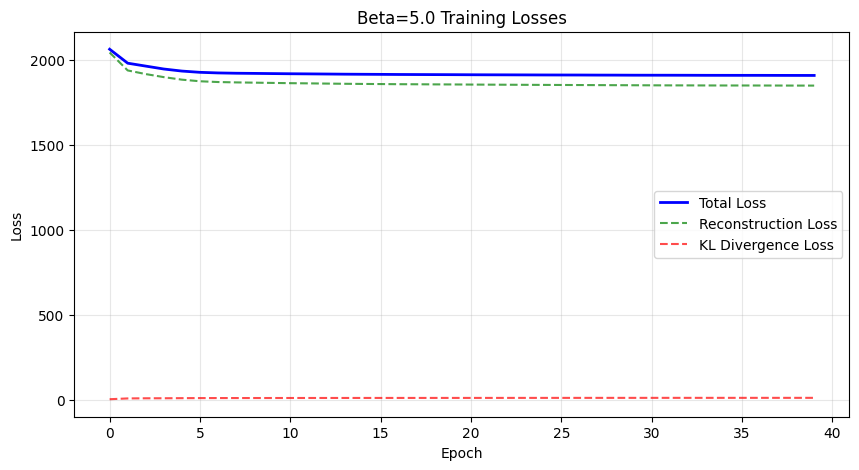

In [13]:
import matplotlib.pyplot as plt

def plot_all_losses(total_losses, recon_losses, kld_losses, title="Training Losses"):
    plt.figure(figsize=(10, 5))
    
    plt.plot(total_losses, label="Total Loss", color='blue', linewidth=2)
    
    plt.plot(recon_losses, label="Reconstruction Loss", color='green', linestyle='--', alpha=0.7)
    
    plt.plot(kld_losses, label="KL Divergence Loss", color='red', linestyle='--', alpha=0.7)
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_all_losses(train_losses_beta5, recon_losses_beta5, kld_losses_beta5, title="Beta=5.0 Training Losses")

## Comparision Between Beta 1 and Beta 5

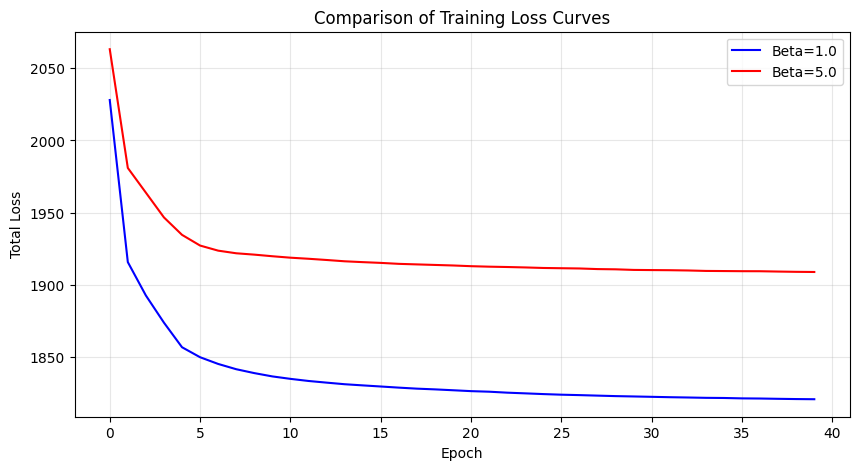

In [14]:
def compare_beta_curves(train_losses_beta1, train_losses_beta5):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_beta1, label='Beta=1.0', color='blue')
    plt.plot(train_losses_beta5, label='Beta=5.0', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.legend()
    plt.title('Comparison of Training Loss Curves')
    plt.grid(True, alpha=0.3)
    plt.show()

compare_beta_curves(train_losses_beta1, train_losses_beta5)

## TASK 3 Image Generation

In [15]:
def generate_image_grid(models, grid_size=4):
    """
    Generates and displays a grid of images for each provided model.
    """
    for name, model in models.items():
        model.eval()
        with torch.no_grad():
            z = torch.randn(grid_size * grid_size, LATENT_DIM).to(DEVICE)
            generated_images = model.decoder(z).cpu()
            
            fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
            fig.suptitle(f"Generated Images ({name})", fontsize=16)
            
            for i in range(grid_size * grid_size):
                row = i // grid_size
                col = i % grid_size
                # Permute (C, H, W) -> (H, W, C) for matplotlib
                axes[row, col].imshow(generated_images[i].permute(1, 2, 0))
                axes[row, col].axis('off')
            
            plt.show()

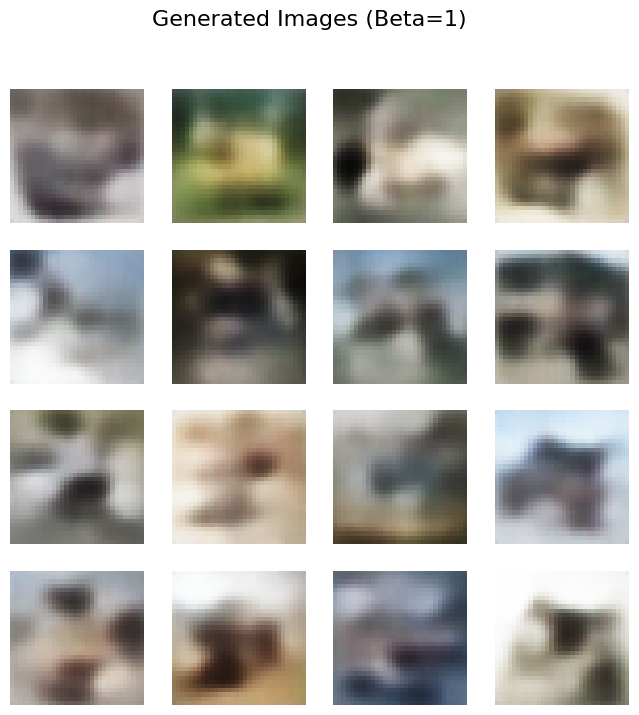

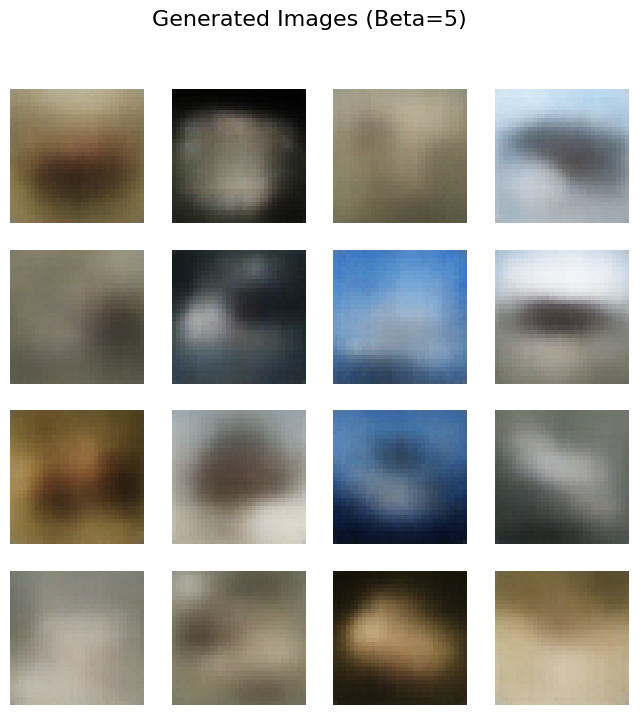

In [16]:
models = {'Beta=1': model_beta1, 'Beta=5': model_beta5}
generate_image_grid(models)

## TASK 4 Latent Space Interpolation

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def interpolate_latent_space(model, steps=10):
    model.eval()

    with torch.no_grad():
        z1 = torch.randn(1, LATENT_DIM).to(DEVICE)
        z2 = torch.randn(1, LATENT_DIM).to(DEVICE)

        alphas = np.linspace(0, 1, steps)
        interpolated_images = []

        for alpha in alphas:
            z_new = (1 - alpha) * z1 + alpha * z2
            reconstructed_img = model.decoder(z_new)
            interpolated_images.append(reconstructed_img.squeeze().cpu())

        fig, axes = plt.subplots(1, steps, figsize=(20, 2))
        for i, img in enumerate(interpolated_images):
            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].axis('off')
        plt.show()

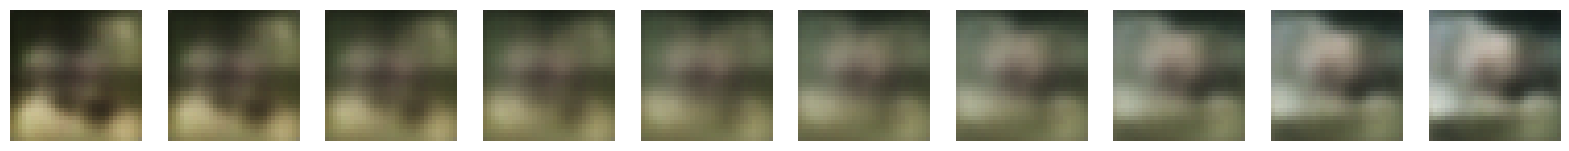

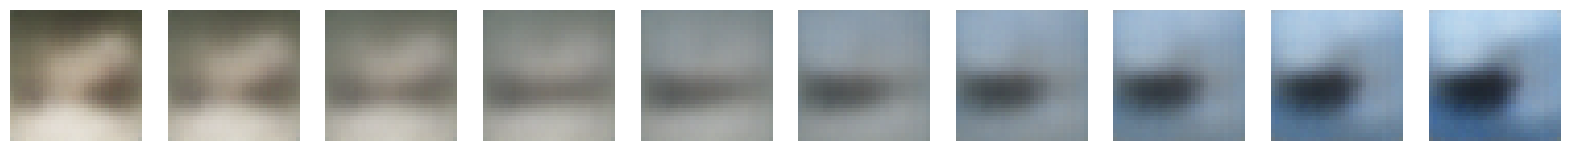

In [18]:
def compare_interpolation(model1, model2, steps=10):
    interpolate_latent_space(model1)
    interpolate_latent_space(model2)

# Call comparison
compare_interpolation(model_beta1, model_beta5)

## B VAE Modification Analysis: 
1. After modify beta training took more time for same number of epoch training it took 10X time. I reduced the epoch count as after 51 epoch it was take unpredictable time.
2. B=5 has more structured latent space and generated smoother transition to another image. 
3. B=5 Image are more blurred compared to B=1 for the same epochs. 

## Summary


For Standard VAE where Beta is 1.0: 
 - reconsutruction loss and totla loss was less comparativliy 
 - reconstruction quality was better. 
 - KL divergence loss was 44. 

 For Beta = 5.0: 
 - KL divergence loss dropped significantely around 12. 
 - Total loss and reconstruction loss got increased comparatively. 
 - 

 